In [95]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt

In [96]:
INPUT_SIZE = 784
NUM_LAYERS = 3
NUM_CLASSES = 10
NUM_EPOCHS = 50
BATCH_SIZE = 10
LEARNING_RATE = 0.1

NUM_SAMPLES = 2000
NUM_TRAIN_SAMPLES = 100

In [97]:
# MNIST dataset 
dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

sample_index=list(range(NUM_SAMPLES))
train_index=list(np.random.choice(range(NUM_SAMPLES),size=NUM_TRAIN_SAMPLES,replace=False))

sample_dataset=Subset(dataset, sample_index)
train_dataset=Subset(sample_dataset, train_index)

# Data loader
TRAIN_LOADER = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

SAMPLE_LOADER = DataLoader(dataset=sample_dataset,batch_size=1,shuffle=False)

In [98]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [99]:
def get_bounds(sample_loader, train_loader, num_samples, num_train, delta, hidden_size, num_layers):
    model = NeuralNet(INPUT_SIZE,hidden_size, num_layers, NUM_CLASSES)
    ReLU_glorot_init(model)
            
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        for images, labels in train_loader:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    train_error=0
    with torch.no_grad():
        for image, label in train_loader:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            loss = criterion(output, label)
            train_error+=loss.item()*len(image)
    train_error=train_error/num_train

    true_error=0
    classifications=[]
    C=0
    with torch.no_grad():
        for image, label in sample_loader:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            loss = criterion(output, label)
            if C<loss.item():
                C=loss.item()
            true_error+=loss.item()
            predictions=output.max(1)[1]
            classifications+=(predictions==label).tolist()
    p_Delta=sum(classifications)/num_samples
    true_error=true_error/num_samples

    bound_point=train_error+C*np.sqrt(np.log(1/delta)/(2*num_train))

    log_component = np.log((1-p_Delta+np.sqrt((1-p_Delta)**2+4*delta**(1/num_train)*p_Delta))/(2*delta**(1/num_train)))

    bound_region=train_error+np.sqrt(C**2*log_component/2)
    
    return train_error, true_error, bound_region, bound_point, p_Delta

In [100]:
LAYER_SIZES=[1,2,3,4]
HIDDEN_SIZES=[4,8,16,32,128,256]
NUM_TESTS=5

true_errors=[]
bounds_region=[]
bounds_point=[]
p_Deltas=[]
for num_layers in LAYER_SIZES:
    for h_size in HIDDEN_SIZES:
        for n in range(NUM_TESTS):
            tr_er, ts_er, b_r, b_p, p = get_bounds(SAMPLE_LOADER, TRAIN_LOADER, NUM_SAMPLES, NUM_TRAIN_SAMPLES, 0.05, h_size, num_layers)
            true_errors.append(ts_er)
            bounds_region.append(b_r)
            bounds_point.append(b_p)
            p_Deltas.append(p)
            print('Number of Layers {} Hidden Size {} Test number {}'.format(num_layers,h_size,n+1))

Number of Layers 1 Hidden Size 4 Test number 1
Number of Layers 1 Hidden Size 4 Test number 2
Number of Layers 1 Hidden Size 4 Test number 3
Number of Layers 1 Hidden Size 4 Test number 4
Number of Layers 1 Hidden Size 4 Test number 5
Number of Layers 1 Hidden Size 8 Test number 1
Number of Layers 1 Hidden Size 8 Test number 2
Number of Layers 1 Hidden Size 8 Test number 3
Number of Layers 1 Hidden Size 8 Test number 4
Number of Layers 1 Hidden Size 8 Test number 5
Number of Layers 1 Hidden Size 16 Test number 1
Number of Layers 1 Hidden Size 16 Test number 2
Number of Layers 1 Hidden Size 16 Test number 3
Number of Layers 1 Hidden Size 16 Test number 4
Number of Layers 1 Hidden Size 16 Test number 5
Number of Layers 1 Hidden Size 32 Test number 1
Number of Layers 1 Hidden Size 32 Test number 2
Number of Layers 1 Hidden Size 32 Test number 3
Number of Layers 1 Hidden Size 32 Test number 4
Number of Layers 1 Hidden Size 32 Test number 5
Number of Layers 1 Hidden Size 128 Test number 1
N

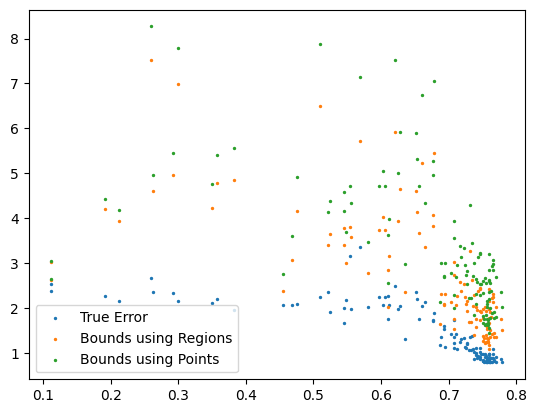

In [103]:
plt.scatter(p_Deltas,true_errors,s=2,label='True Error')
plt.scatter(p_Deltas,bounds_region,s=2,label='Bounds using Regions')
plt.scatter(p_Deltas,bounds_point,s=2,label='Bounds using Points')
plt.legend()
plt.savefig('plots/Region_against_Point_Bounds.png')